## comp_mean_grid
Compute grid-related variables from time-average data (SSH), including corrections for vertical grid metrics

Namely:
* corrected e3t and e3w
* hbot (bottom depth)

Strategy: first copy all vars in zarr file, then compute correction reading from zarr file (faster)

Total timing is shorter than 10 minutes, max RAM used is around 60 GB

In [1]:
from pathlib import Path
import os, datetime
#import numpy as np

import xarray as xr
from xorca.lib import load_xorca_dataset
import itidenatl.gridop as gop
import itidenatl.utils as ut

In [2]:
scratch = Path(os.getenv("SCRATCHDIR"))
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(n_workers=8, local_directory=scratch) #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:37281 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


## Define parameters

In [29]:
client.restart()

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_t

Client Scheduler: tcp://127.0.0.1:37281 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


In [30]:
### Path, directories, filenames...
workdir = Path("/work/CT1/ige2071/nlahaye")

grid_dir = scratch #Path("/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-I/")
mean_dir = Path("/work/CT1/ige2071/SHARED/mean")
out_dir = scratch

avg_type = "30d" # "30d" or "global"
avg_date = "20100327" # will be ignored if avg_type is "global"
    
grid_fname = "mesh_mask_eNATL60_3.6.nc"
ssh_fname = "_".join([avg_type, "mean_gridT-2D"])+".zarr"
out_fname = "eNATL60_{}-mean_z-grid.zarr".format(avg_type)

if avg_type == "30d":
    ssh_fname = ssh_fname.replace(".zarr", "_"+avg_date+".zarr")
    out_fname = out_fname.replace(".zarr", "_"+avg_date+".zarr")
    
out_file = out_dir/out_fname
grid_file = grid_dir/grid_fname

### Chunking
out_chks = {"x":-1, "y":200, "z":10} # output chunking

### Load variables and coordinates from grid file and copy them in zarr archive with target chunking

In [31]:
%%time
### load needed vars and copy them in zarr archive with target chunking
### storing uses <7GB ram and takes < 3 min on a one-node cluster

# define a few things
varnames = ["depth_c_3d", "depth_l_3d", "e3t", "e3w"]
coords = ["tmaskutil", "llon_cc", "llat_cc", "depth_c", "depth_l"]
inp_chks = {"x":-1, "y":10, "z":1} # this is the chunking of the initial grid file

# use xorca to get the coordinates (around 20 s)
chunks = {dim:out_chks[dim[0]] for dim in ["x_c", "x_r", "y_c", "y_r", "z_c", "z_l"]}
ds = load_xorca_dataset(data_files=[], aux_files=[grid_file],
                        decode_cf=True, model_config="nest",
                        target_ds_chunks=chunks, input_ds_chunks=inp_chks
                       )
ds = ds.drop_dims(("y_r", "x_r"))
ds = ds.drop([c for c in ds.coords if c not in coords and c not in ds.dims])
ds = ds.persist()

# deal with attributes
ds.attrs = {"from_files": [str(grid_file), str(mean_dir/ssh_fname)],
            "simulation": "eNATL60", 
            "date_processed": datetime.datetime.today().isoformat(timespec="minutes"),
            "processing notebook":"comp_mean_grid.ipynb"
           }
sdd = xr.open_zarr(mean_dir/ssh_fname).get(["time_start", "time_end"]).load()
ds.attrs.update({k:str(v.values[0]) for k,v in sdd.data_vars.items() })

ds

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


CPU times: user 30 s, sys: 2.55 s, total: 32.5 s
Wall time: 34.8 s


<xarray.Dataset>
Dimensions:    (z_c: 300, z_l: 300, y_c: 4729, x_c: 8354)
Coordinates:
  * z_c        (z_c) int64 1 2 3 4 5 6 7 8 9 ... 293 294 295 296 297 298 299 300
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
    depth_c    (z_c) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    depth_l    (z_l) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 8354), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 8354), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(200, 8354), meta=np.ndarray>
Data variables:
    *empty*
Attributes:
    from_files:           ['/scratch/cnt0024/ige2071/nlahaye/mesh_mask_eNATL6...
    simulation:           eNATL60
    date_processed:       2022-04-07T10:34
    processing notebook:  comp_mean_grid.ipynb
    time_start:           2010-03-27T00:00:00.000000000
    time_end:             2010-04-25T00:00:00.000000000

In [32]:
%%time

# use specific routine to load 3D variables more efficiently
ds = ds.merge(ut.open_one_coord(grid_file, "tmask", chunks=out_chks).persist(), combine_attrs="override")
wmask = ds.tmask.rename({"z_c":"z_l"})
wmask = wmask.drop([c for c in wmask.coords]).persist()
for v in varnames:
    da = ut.open_one_coord(grid_file, v, chunks=out_chks).astype("float32")
    if "z_c" in da.dims:
        ds = ds.merge(da.where(ds.tmask), combine_attrs="override")
    elif "z_l" in da.dims:
        ds = ds.merge(da.where(wmask), combine_attrs="override")
    else:
        ds = ds.merge(da.where(ds.tmaskutil), combine_attrs="override")
    #ds = ds.merge(xr.merge([ut.open_one_coord(grid_file, v, chunks=out_chks) 
    #                   for v in varnames]), 
    #          combine_attrs="override") # this way attrx of core dims are preserved
print("dataset is {:.1f} GB".format(ds.nbytes/1e9))

### store in zarr archive. ~3 minutes, < 10 GB
ds.to_zarr(out_file, mode="w", compute=True, consolidated=True)

dataset is 201.8 GB
CPU times: user 2min 22s, sys: 15.9 s, total: 2min 38s
Wall time: 4min 47s


In [33]:
### getting rid of persisted stuff
client.restart()

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/multiprocessing/semaphore_tracker.py:144: UserWarning: semaphore_tracker: There appear to be 1 leaked semaphores to clean up at shutdown
  len(cache))


Client Scheduler: tcp://127.0.0.1:37281 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


In [34]:
%%time
### load ssh, compute hbot and store: 
#               - around 1 min and 12 GB ram if reading from netcdf. 
#               - 30 s and 60 GB if reading from zarr

dimap = {"x":"x_c", "y":"y_c"}
def get_var(path, varname):
    da = xr.open_zarr(path)[varname].squeeze()
    da = da.chunk({dim:out_chks[dim] for dim in da.dims}).rename({dim:dimap[dim] for dim in da.dims})
    return da

if True: # reading from zarr
    ds = xr.open_zarr(out_file)
ds["sossheig"] = get_var(mean_dir/ssh_fname, "sossheig")
ds["hbot"] = gop.get_hbot(ds, overwrite=True)#.persist() 

# compute and store (drop every coords so that they are not overwritten)
for v in ds.data_vars:
    ds[v].encoding.pop("chunks", None)
for c in ds.coords:
    ds[c].encoding.pop("chunks", None)
to_store = ds.get(["sossheig", "hbot"])
to_store = to_store.drop([c for c in to_store.coords]) 
to_store.to_zarr(out_file, mode="a", compute=True, consolidated=True)

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  import sys


CPU times: user 13.3 s, sys: 1.53 s, total: 14.9 s
Wall time: 26 s


## compute corrected grid (depth and metrics) and store
reading from zarr : very fast

In [35]:
%%time
# compute and store correction for e3t and e3w: ~50 s and ~60 GB ram
ds = xr.open_zarr(out_file)   
lacorr = (1. + ds.sossheig / ds.hbot).astype("float32").persist() # cf gridop.get_rec_e3z

### compute corrected vertical grid metrics and store in zarr
to_store = (ds.get(["e3t", "e3w"]) * lacorr)#.astype("float32") #.where(ds.tmaskutil)
to_store = to_store.drop([c for c in to_store.coords])
to_store.attrs = ds.attrs
to_store.to_zarr(out_file, mode="a", compute=True, consolidated=True)

CPU times: user 17.8 s, sys: 1.97 s, total: 19.8 s
Wall time: 30 s


In [36]:
%%time
### compute corrected 3D depth grids: ~50 s and ~40 GB ram
to_store = ds.get(["depth_c_3d","depth_l_3d"]) * lacorr + ds.sossheig#.astype("float32")
#to_store = to_store.where(ds.tmaskutil)
to_store = to_store.drop([c for c in to_store.coords])
to_store.attrs = ds.attrs
to_store.to_zarr(out_file, mode="a", compute=True, consolidated=True)

CPU times: user 19.6 s, sys: 2.23 s, total: 21.9 s
Wall time: 37.6 s


In [37]:
out_file

PosixPath('/scratch/cnt0024/ige2071/nlahaye/eNATL60_30d-mean_z-grid_20100327.zarr')

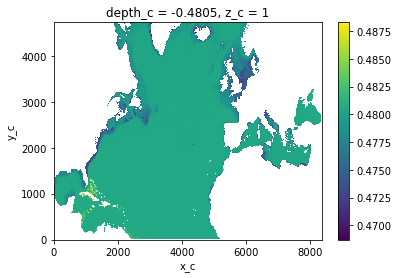

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_t

In [38]:
dsr = xr.open_zarr(out_file)
slih = slice(0, None, 10)
(dsr.sossheig - dsr.depth_c_3d.isel(z_c=0)).isel(x_c=slih, y_c=slih).plot()

In [38]:
client.close()
cluster.close()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


This is the end of the notebook

## post processing
rechunking. This has not been cleaned out. Not useful in the most recent version (provided the correct chunking is targeted before execution of the notebook).

In [4]:
ds_re = xr.open_zarr(out_file)
chk_xy, chk_z = 200, 300
new_chks = {d:chk_z for d in ds_re.dims if d.startswith("z")}
new_chks.update({d:chk_xy for d in ["x_c","y_c"]})
ds_re = ds_re.chunk(new_chks)

### remove encoding "chunks" to write with zarr
for k in ds_re.coords.values():
    print(k.name, k.encoding.pop("chunks", None))
for k in ds_re.data_vars.values():
    print(k.name, k.encoding.pop("chunks", None))
    
ds_re

depth_c (10,)
depth_l (10,)
llat_cc (1200, 1200)
llon_cc (1200, 1200)
tmaskutil (1200, 1200)
x_c (8354,)
y_c (4729,)
z_c (300,)
z_l (300,)
depth_c_3d (10, 1200, 1200)
depth_l_3d (10, 1200, 1200)
e3t (10, 1200, 1200)
e3w (10, 1200, 1200)
hbot (1200, 1200)
sossheig (1200, 1200)
tmask (10, 1200, 1200)


<xarray.Dataset>
Dimensions:     (x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates:
    depth_c     (z_c) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    llat_cc     (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    llon_cc     (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c         (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    depth_c_3d  (z_c, y_c, x_c) float32 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
    depth_l_3d  (z_l, y_c, x_c) float32 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
    e3t         (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
    e3w         (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
    hbot        (y_c, x_c) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    sossheig    (y_c, x_c) float64 dask.array<chunksize=(200, 200), meta=np.ndarray>
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>

In [5]:
out_new = out_file.parent/(out_file.stem+"_one-chk-z.zarr")
out_new

PosixPath('/scratch/cnt0024/ige2071/nlahaye/eNATL60_mean_grid_z_one-chk-z.zarr')

In [10]:
client.restart()

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing


Client Scheduler: tcp://127.0.0.1:34619 Dashboard: http://127.0.0.1:46806/status,Cluster Workers: 7 Cores: 56 Memory: 236.33 GiB


In [37]:
%%time
ds_re.to_zarr(out_new, mode="w", compute=False, consolidated=True)

CPU times: user 3.61 s, sys: 655 ms, total: 4.27 s
Wall time: 5.44 s


Delayed('_finalize_store-8cd984fe-0fae-422a-9f44-d4ea96e38403')

In [6]:
%%time
ds_re.get([v for v in ds_re.data_vars if len(ds_re[v].dims)<3]).to_zarr(out_new, mode="a")

CPU times: user 7.52 s, sys: 404 ms, total: 7.93 s
Wall time: 9.52 s


In [9]:
%%time
les_var = [v for v in ds_re.data_vars if len(ds_re[v].dims)>=3]
print("copying")
for v in les_var:
    ds_re.get([v]).to_zarr(out_new, mode="a")
    print("v", end=", ")
print("done")

copying
v, v, v, v, v, done
CPU times: user 2min 1s, sys: 8.76 s, total: 2min 10s
Wall time: 4min 9s
